<a href="https://colab.research.google.com/github/Bint7bara/KerasEvaluateModule/blob/master/Copy_of_ensemble_keras_binary_classifier_33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install  tensorflow_decision_forests==0.2.5
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_decision_forests as tfdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.8 MB 5.2 MB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
seed = 7

# load pima indians dataset
dataset = np.loadtxt("12Featuresplus_LncAdeepScores.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:33]
Y = dataset[:,33]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=0.2, random_state=42
)
X_train,y_train

(array([[3.33734280e-02, 2.36713350e-02, 1.28940000e+00, ...,
         9.95438597e-01, 9.94353814e-01, 9.96189210e-01],
        [4.19000000e-05, 5.80375000e-04, 7.47100000e-01, ...,
         1.66586870e-02, 2.98932130e-02, 1.84488600e-02],
        [1.85000000e-08, 7.24000000e-08, 9.92600000e-01, ...,
         9.96055408e-01, 9.96069205e-01, 9.93785686e-01],
        ...,
        [1.29000000e-05, 1.96000000e-05, 6.81000000e-01, ...,
         2.00419280e-02, 2.00546250e-02, 2.06564850e-02],
        [0.00000000e+00, 2.72000000e-08, 8.30500000e-01, ...,
         9.53203621e-01, 9.64487969e-01, 9.60648392e-01],
        [7.57000000e-05, 1.71000000e-05, 9.14000000e-01, ...,
         9.98267432e-01, 9.97279950e-01, 9.97481351e-01]]),
 array([1., 0., 1., ..., 0., 1., 1.]))

In [ ]:
# Input features.
num_features = 33
raw_features = tf.keras.layers.Input(shape=(num_features,))

# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf.keras.layers.Dense(12, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(preprocess_features)
m1_z1 = tf.keras.layers.Dropout(0.2)(m1_z1)
m1_z1 = tf.keras.layers.Dense(20, activation='relu')(m1_z1)
m1_z1 = tf.keras.layers.Dropout(0.2)(m1_z1)
m1_z1 = tf.keras.layers.Dense(12, activation='relu')(m1_z1)
m1_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)
# Model #2: NN
m2_z2 = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(preprocess_features)
m2_z2 = tf.keras.layers.Dropout(0.2)(m2_z2)
m2_z2 = tf.keras.layers.Dense(20, activation='relu')(m2_z2)
m2_z2 = tf.keras.layers.Dropout(0.2)(m2_z2)
m2_z2 = tf.keras.layers.Dense(15, activation='relu')(m2_z2)
m2_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z2)
# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(
    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_nn_only = tf.keras.models.Model(raw_features, mean_nn_only)
ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

Use /tmp/tmpluiyoiro as temporary training directory


Use /tmp/tmp91jfyie9 as temporary training directory


In [ ]:
def make_tf_dataset(features, labels, batch_size=128, **args):
  # features, labels = make_dataset(**args)
  return tf.data.Dataset.from_tensor_slices(
      (features, labels)).batch(batch_size)


num_features = 33

train_dataset = make_tf_dataset(X_train, y_train)
    # num_examples=2500, num_features=num_features, batch_size=100, seed=1234)
test_dataset = make_tf_dataset(X_test, y_test)
    # num_examples=10000, num_features=num_features, batch_size=100, seed=5678)

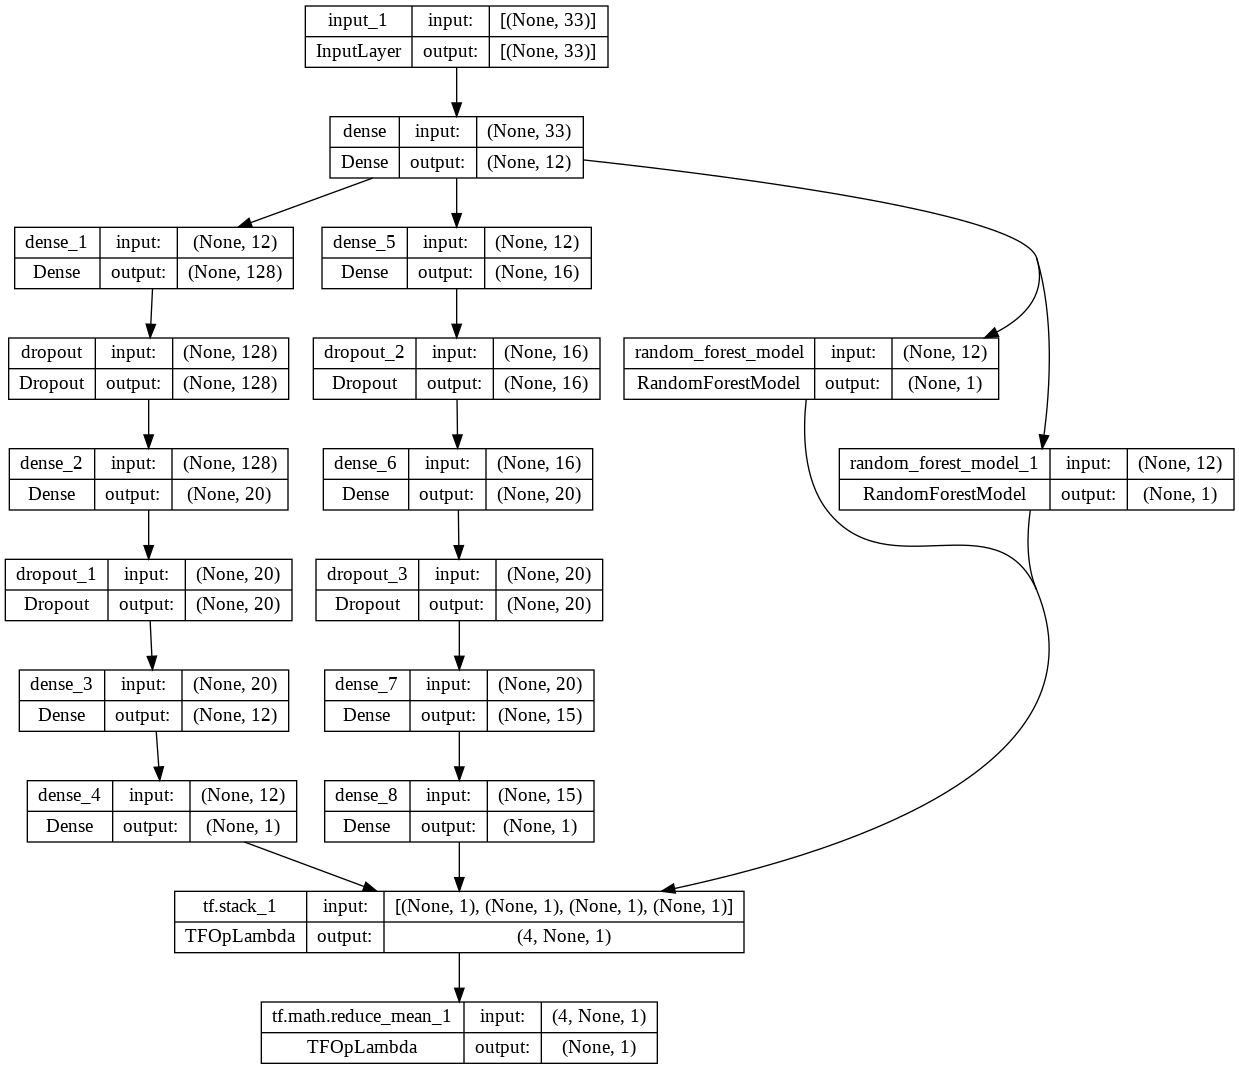

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_and_df, to_file="/tmp/model.png", show_shapes=True)

In [ ]:
%%time
ensemble_nn_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

ensemble_nn_only.fit(
    train_dataset,
    batch_size=128,
    epochs=120,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(test_dataset),
)

Epoch 1/120
153/153 [==============================] - 6s 16ms/step - loss: 0.6360 - accuracy: 0.6284 - val_loss: 0.3301 - val_accuracy: 0.8672
Epoch 2/120
153/153 [==============================] - 2s 11ms/step - loss: 0.2876 - accuracy: 0.9010 - val_loss: 0.1954 - val_accuracy: 0.9329
Epoch 3/120
153/153 [==============================] - 2s 12ms/step - loss: 0.1515 - accuracy: 0.9557 - val_loss: 0.1170 - val_accuracy: 0.9692
Epoch 4/120
153/153 [==============================] - 2s 11ms/step - loss: 0.1284 - accuracy: 0.9656 - val_loss: 0.1108 - val_accuracy: 0.9680
Epoch 5/120
153/153 [==============================] - 2s 12ms/step - loss: 0.1237 - accuracy: 0.9655 - val_loss: 0.1137 - val_accuracy: 0.9680
Epoch 6/120
153/153 [==============================] - 2s 12ms/step - loss: 0.1184 - accuracy: 0.9649 - val_loss: 0.1092 - val_accuracy: 0.9690
Epoch 7/120
153/153 [==============================] - 2s 10ms/step - loss: 0.1191 - accuracy: 0.9667 - val_loss: 0.1083 - val_accuracy:

In [ ]:
evaluation_nn_only = ensemble_nn_only.evaluate(test_dataset, return_dict=True, batch_size=128)
print("test loss, test acc:", evaluation_nn_only)

39/39 [==============================] - 0s 2ms/step - loss: 0.1068 - accuracy: 0.9713
test loss, test acc: {'loss': 0.10678786784410477, 'accuracy': 0.9712584614753723}


In [ ]:
model_3.compile(["accuracy"])
model_4.compile(["accuracy"])


In [ ]:
%time
#train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
#test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))
#%time
train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
model_3.fit(train_dataset_with_preprocessing)
model_4.fit(train_dataset_with_preprocessing)
#model_3.fit(X_train,y_train)
#model_4.fit(X_train,y_train)
#model_3.fit(preprocessor(X_train),y_train)
#model_4.fit(preprocessor(X_train),y_train)


Reading training dataset...
Training dataset read in 0:00:05.010836. Found 19483 examples.
Training model...
Model trained in 0:00:44.430071
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.347281. Found 19483 examples.
Training model...
Model trained in 0:00:37.137703
Compiling model...
Model compiled.


In [ ]:

#evaluation_df3_only = model_3.evaluate(
 #   X_test, y_test, return_dict=True)
#evaluation_df4_only = model_4.evaluate(
 #   X_test,y_test, return_dict=True)


In [ ]:
evaluation_df3_only = model_3.evaluate(
    test_dataset_with_preprocessing, return_dict=True)
evaluation_df4_only = model_4.evaluate(
    test_dataset_with_preprocessing, return_dict=True)

39/39 [==============================] - 1s 19ms/step - loss: 0.0000e+00 - accuracy: 0.9688


In [ ]:
print("Accuracy (DF #3 only): ", evaluation_df3_only["accuracy"])
print("Accuracy (DF #4 only): ", evaluation_df4_only["accuracy"])

Accuracy (DF #3 only):  0.96941077709198
Accuracy (DF #4 only):  0.9687948822975159


In [ ]:
ensemble_nn_and_df.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


evaluation_nn_and_df = ensemble_nn_and_df.evaluate(test_dataset,return_dict=True)



39/39 [==============================] - 2s 30ms/step - loss: 0.1059 - accuracy: 0.9702


In [ ]:
print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

Accuracy (2xNN and 2xDF):  0.9702320098876953
Loss (2xNN and 2xDF):  0.105904720723629


In [ ]:
mean_df_only = tf.reduce_mean(tf.stack([m3_pred, m4_pred], axis=0), axis=0)
# mean_nn_and_df = tf.reduce_mean(
#    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_df_only = tf.keras.models.Model(raw_features, mean_df_only)
#ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

In [ ]:
%%time
ensemble_df_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])


CPU times: user 6.36 ms, sys: 37 µs, total: 6.39 ms
Wall time: 6.55 ms


In [ ]:
# ensemble_df_only.fit(
  #  X_train,
   # y_train,
    # batch_size=64,
    # epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(X_test, y_test),
#)

In [ ]:
#ensemble_nn_and_df.compile(
#    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


evaluation_df_only = ensemble_df_only.evaluate(test_dataset, return_dict=True)

print("Accuracy (2xNN and 2xDF): ", evaluation_df_only["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_df_only["loss"])

39/39 [==============================] - 1s 31ms/step - loss: 0.2075 - accuracy: 0.9692
Accuracy (2xNN and 2xDF):  0.9692054986953735
Loss (2xNN and 2xDF):  0.20745930075645447


In [ ]:
ensemble_nn_and_df.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

evaluation_nn_and_df = ensemble_nn_and_df.evaluate(
    test_dataset, return_dict=True)

print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

39/39 [==============================] - 1s 29ms/step - loss: 0.1059 - accuracy: 0.9702
Accuracy (2xNN and 2xDF):  0.9702320098876953
Loss (2xNN and 2xDF):  0.105904720723629


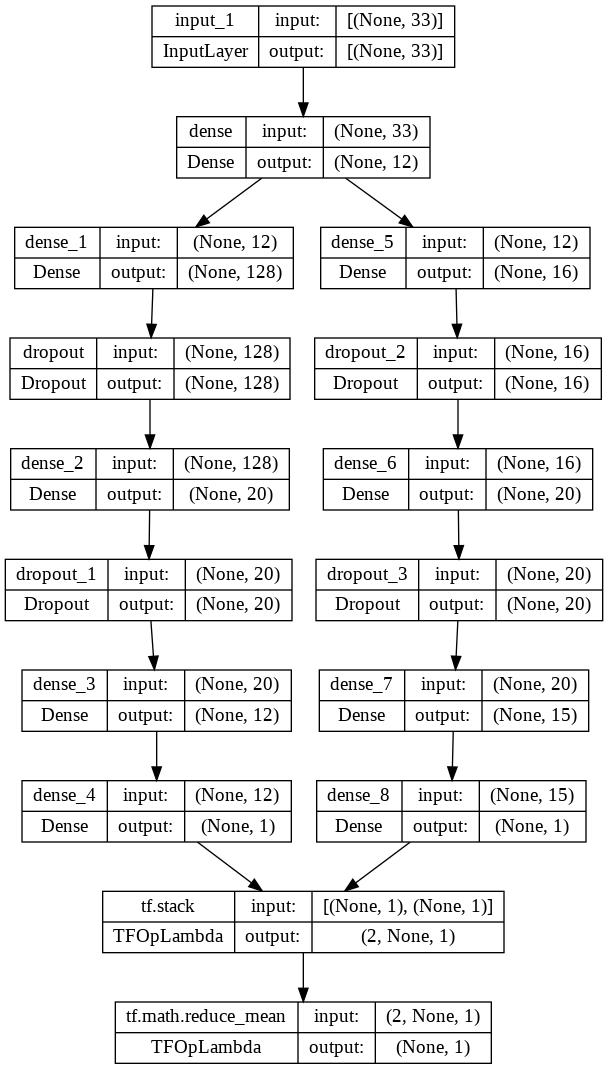

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_only, to_file="/tmp/model-nn-only.png", show_shapes=True)

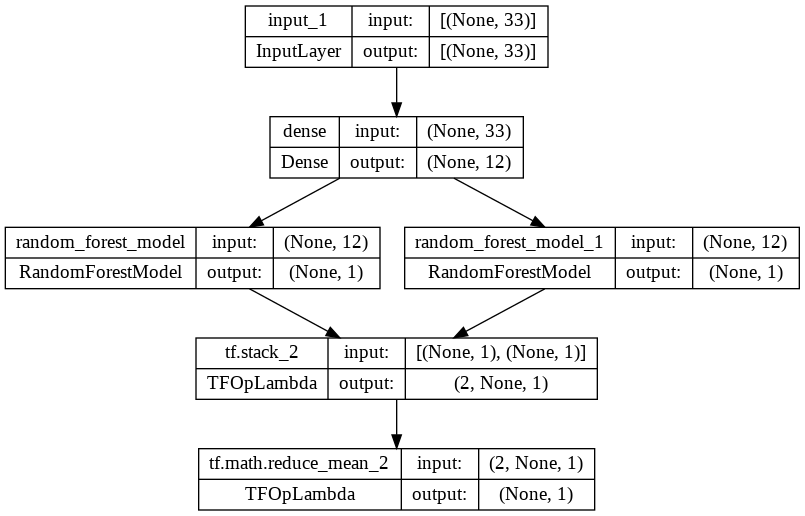

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_df_only, to_file="/tmp/model-df-only.png", show_shapes=True)

In [ ]:
def make_dataset(num_examples, num_features, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, num_features))
  noise = np.random.uniform(size=(num_examples))

  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5

  labels = left_side <= right_side
  return features, labels.astype(int)

In [ ]:
example_dataset = make_dataset(num_examples=5, num_features=4)

In [ ]:
# train_dataset = (X_train, y_train)
# test_dataset = (X_test, y_test)

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [4, 5, 6, 7])
tuner.choice("min_examples", [2, 5, 7, 10])
#tuner.choice("n_estimators", [300])
#tuner.choice("criterion", ['gini','entropy'])
#tuner.choice("min_samples_split", [4,5,10])
model = tfdf.keras.RandomForestModel(tuner=tuner)
model.fit(test_dataset_with_preprocessing)

print(model.summary())

Use /tmp/tmp5rvpm1gf as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.260740. Found 4871 examples.
Training model...
Model trained in 0:00:18.440390
Compiling model...
Model compiled.
Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "data:0.0"  2.985810 ################
    2.  "data:0.1"  2.985810 ################
    3. "data:0.11"  2.985810 ################
    4.  "data:0.2"  2.985810 ################
    5.  "data:0.7"  2.985810 ################
    6.   "__LABEL"  2.985810 ################
    7. "data:0.10"  2.984976 #####